In [1]:
# Install needed packages
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

In [2]:
install('graphviz')

# Random forest DMS

This script runs the random forest model on the data from the differences in fitness effects observed in our DMS with and without TMP

Useful links on selecting variables:

https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e

https://explained.ai/rf-importance/index.html#intro

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from IPython.display import HTML

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from statistics import mean

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

from rfpimp import permutation_importances
from sklearn.base import clone 

from sklearn import tree
import graphviz
from sklearn.tree import _tree

In [39]:
import sklearn
sklearn.__version__

'0.24.2'

In [2]:
dataset = pd.read_csv('../../Data/dataset_diffNorm_ara0.2_ara0.01_index_differences_new.txt', sep='\t')
dataset

,Position,WT_Residue,Residue,mean_sel_coeff,Arabinose,mean_sel_coeff_2,Arabinose_2,diffNormScore,Mean_ddG_stab_HET,Mean_ddG_int_HM_A_B,...,recognition_factors,refractivity,relative_mutability_ala100_dayhoff,retention_coefficient_hfba_browne,retention_coefficient_ph2.1_meek,retention_coefficient_ph7.4_meek,retention_coefficient_tfa_browne,total_beta_strand_lifson,transmembrane_tendency_zhao,levy_propensity
0,2,E,*,-0.111687,0.2,-0.042169,0.01,0.069518,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,E,A,0.078380,0.2,0.364839,0.01,0.286459,NaN,NaN,...,0.0,-12.92,-2.0,11.4,7.4,17.4,14.4,0.31,3.28,0.7955
2,2,E,C,0.072816,0.2,0.386025,0.01,0.313209,NaN,NaN,...,11.0,18.51,-82.0,-6.8,5.3,10.1,-2.1,0.55,2.60,1.8265
3,2,E,D,0.070843,0.2,0.131240,0.01,0.060397,NaN,NaN,...,3.0,-5.26,4.0,4.7,4.7,8.7,4.2,-0.13,-0.37,0.0408
4,2,E,E,0.000328,0.2,0.003674,0.01,0.003346,NaN,NaN,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1612,78,N,S,0.053429,0.2,0.062348,0.01,0.008919,-0.05281,0.0,...,13.0,-6.93,-14.0,-0.7,-2.1,0.4,1.6,0.22,1.09,0.4069
1613,78,N,T,0.055354,0.2,0.066695,0.01,0.011341,0.01204,0.0,...,-1.0,-2.27,-37.0,3.9,3.1,1.9,6.5,0.52,1.30,0.3724
1614,78,N,V,0.040449,0.2,0.036648,0.01,-0.003801,0.17377,0.0,...,-5.0,0.64,-60.0,4.9,4.9,1.9,9.2,1.21,3.08,1.0292
1615,78,N,W,0.038840,0.2,-0.087122,0.01,-0.125962,-0.11735,0.0,...,10.0,29.25,-116.0,20.6,19.7,14.1,22.0,0.94,3.15,1.0618


In [3]:
dataset['Mean_ddG_stab_HET']

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
1612   -0.05281
1613    0.01204
1614    0.17377
1615   -0.11735
1616   -0.04273
Name: Mean_ddG_stab_HET, Length: 1617, dtype: float64

In [4]:
# Remove stop codons and rows that are not present in the PDB structure
dataset = dataset[(dataset['Residue'] != '*') & 
                  (pd.notna(dataset['Mean_ddG_stab_HET'])) &
                  (pd.notna(dataset['diffNormScore']))
                 ]

df = dataset.drop(['Entropy','Position','WT_Residue', 'Residue', 'Arabinose',
                   'Secondary_structure','Solvent_accessibility', 'mean_sel_coeff', 
                   'mean_sel_coeff_2', 'Arabinose_2'],axis=1)

In [5]:
df

,diffNormScore,Mean_ddG_stab_HET,Mean_ddG_int_HM_A_B,Mean_ddG_int_HM_A_C,Mean_ddG_int_HM_A_D,rSASA,alpha_helix_chou,alpha_helix_deleage,alpha_helix_levitt,aminoacid_composition_swissprot_bairoch,...,recognition_factors,refractivity,relative_mutability_ala100_dayhoff,retention_coefficient_hfba_browne,retention_coefficient_ph2.1_meek,retention_coefficient_ph7.4_meek,retention_coefficient_tfa_browne,total_beta_strand_lifson,transmembrane_tendency_zhao,levy_propensity
421,-0.000129,0.00000,0.0,0.00000,0.0,1.07,0.00,0.000,0.00,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0000
422,-0.022686,0.08217,0.0,-0.07334,0.0,1.07,-0.72,-0.523,-0.18,-6.88,...,11.0,31.43,-80.0,-18.2,-2.1,-7.3,-16.5,0.24,-0.68,1.0310
423,-0.139569,0.42867,0.0,-0.03732,0.0,1.07,-0.41,-0.565,-0.25,-2.80,...,3.0,7.66,6.0,-6.7,-2.7,-8.7,-10.2,-0.44,-3.65,-0.7547
424,-0.212631,0.12224,0.0,-0.14038,0.0,1.07,0.09,0.015,0.15,-1.50,...,0.0,12.92,2.0,-11.4,-7.4,-17.4,-14.4,-0.31,-3.28,-0.7955
425,-0.104873,-0.52836,0.0,-0.48634,0.0,1.07,-0.29,-0.294,-0.22,-4.39,...,3.0,25.06,-59.0,10.8,14.0,12.7,11.9,0.33,1.60,1.2665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1612,0.008919,-0.05281,0.0,0.00000,0.0,1.16,0.10,-0.033,-0.08,2.50,...,13.0,-6.93,-14.0,-0.7,-2.1,0.4,1.6,0.22,1.09,0.4069
1613,0.011341,0.01204,0.0,0.00000,0.0,1.16,0.16,0.013,-0.08,1.28,...,-1.0,-2.27,-37.0,3.9,3.1,1.9,6.5,0.52,1.30,0.3724
1614,-0.003801,0.17377,0.0,0.00000,0.0,1.16,0.39,0.218,0.01,2.81,...,-5.0,0.64,-60.0,4.9,4.9,1.9,9.2,1.21,3.08,1.0292
1615,-0.125962,-0.11735,0.0,0.00000,0.0,1.16,0.41,0.318,0.09,-2.98,...,10.0,29.25,-116.0,20.6,19.7,14.1,22.0,0.94,3.15,1.0618


In [6]:
X = df.drop(['diffNormScore'],axis=1)
Y = df['diffNormScore']

# Normalize all the features to the range of -1 , 1
X = X / X.max()

In [7]:
## Let's try using a random forest model
X_train,X_test,y_train,y_test =train_test_split(X,Y,test_size=0.2, random_state=100)

model_rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=100)
model_rf.fit(X_train, y_train) 
pred_train_rf= model_rf.predict(X_train)

print('Mean squared error (train):', np.sqrt(mean_squared_error(y_train,pred_train_rf)))
print('R2 score (train):', r2_score(y_train, pred_train_rf))

pred_test_rf = model_rf.predict(X_test)

print('Mean squared error (test):', np.sqrt(mean_squared_error(y_test,pred_test_rf)))
print('R2 score (test):', r2_score(y_test, pred_test_rf))

Mean squared error (train): 0.046380732377507616
R2 score (train): 0.9086426615856686
Mean squared error (test): 0.12276302664662157
R2 score (test): 0.2550551801728743


In [8]:
## Let's train the random forest again but adding a random variable
np.random.seed(100)
X['random_var'] = np.random.normal(loc = 0, scale = 1, size = X.shape[0])

## Let's try using a random forest model
X_train,X_test,y_train,y_test =train_test_split(X,Y,test_size=0.2, random_state = 100)

model_rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=100)
model_rf.fit(X_train, y_train) 
pred_train_rf= model_rf.predict(X_train)

print('Mean squared error (train):', np.sqrt(mean_squared_error(y_train,pred_train_rf)))
print('R2 score (train):', r2_score(y_train, pred_train_rf))

pred_test_rf = model_rf.predict(X_test)

print('Mean squared error (test):', np.sqrt(mean_squared_error(y_test,pred_test_rf)))
print('R2 score (test):', r2_score(y_test, pred_test_rf))

Mean squared error (train): 0.0464853803248438
R2 score (train): 0.9082299409202684
Mean squared error (test): 0.12256718508749456
R2 score (test): 0.2574300774077466


Let's try using cross-validation

In [9]:
# Use permutation to estimate relative importances
def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

In [12]:
cross_val_n = 5
print('Five-fold cross validation of the random forest model:')
cross_validations = cross_val_score(estimator = model_rf, X = X_train, y = y_train, cv=cross_val_n , scoring = r2)
print(cross_validations)
print(np.mean(cross_validations), np.std(cross_validations) / np.sqrt(cross_val_n))
print('------')

Five-fold cross validation of the random forest model:
[0.42026654 0.26757304 0.37548971 0.17737478 0.28976546]
0.3060939061359988 0.03803695892008682
------


Accuracies for 10-fold cross-validation:

[0.40668556 0.4075551  0.14608703 0.3745234  0.4253721  0.32141851
 0.27220358 0.09478068 0.15936883 0.33988436]

In [13]:

cross_validations = cross_val_score(estimator = model_rf, X = X_train, y = y_train, cv=5, scoring = r2)
print(cross_validations)



[0.42026654 0.26757304 0.37548971 0.17737478 0.28976546]


In [14]:
## Try using cross_val_predict to see how the cross-validation predicted each data point when it was in the
## test set
cross_validations_pred = cross_val_predict(estimator = model_rf, X = X_train, y = y_train, cv=5)

In [15]:
print(len(cross_validations_pred))
print(len(y_train))

912
912


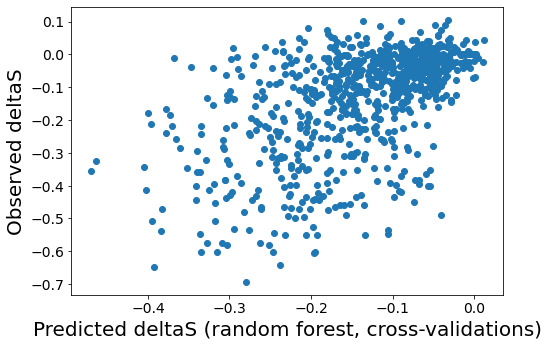

In [16]:
%matplotlib inline
## Let's get a scatterplot of the random forest predictions 
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
# ax = fig.add_axes()
ax.scatter(cross_validations_pred, y_train)
ax.set_xlabel('Predicted deltaS (random forest, cross-validations)', fontsize = 20)
ax.set_ylabel('Observed deltaS', fontsize = 20)
cross_validations_pred[1, ]
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

plt.show()

Figures for the accuracy of the predictions and selecting the best variables

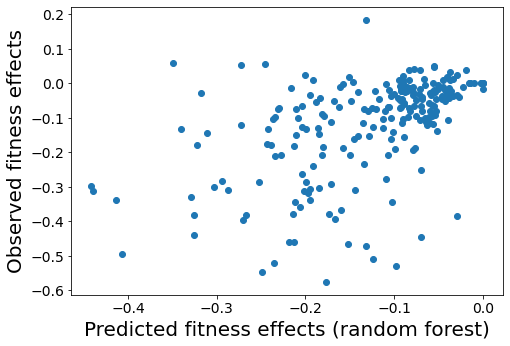

In [17]:
%matplotlib inline
## Let's get a scatterplot of the random forest predictions 
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
# ax = fig.add_axes()
ax.scatter(pred_test_rf, y_test)
ax.set_xlabel('Predicted fitness effects (random forest)', fontsize = 20)
ax.set_ylabel('Observed fitness effects', fontsize = 20)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

plt.show()

In [18]:
## Should save the corresponding files for predictions on validation set and test set
# Save test data and predictions to repeat figures in R

## Results with all variables
df_pred_test = pd.DataFrame(list(zip(y_test,  pred_test_rf)), columns = ['test_data', 'pred_data'])
df_pred_test.to_csv('../../Results_ML/diffNorm_ara0.2_ara0.01/pred_rf_allVariables.txt', sep = '\t')

## Results of predictions in the cross-validation
df_pred_crossval = pd.DataFrame(list(zip(y_train, cross_validations_pred)), columns = ['test_data', 'pred_data'])
df_pred_crossval.to_csv('../../Results_ML/diffNorm_ara0.2_ara0.01/crossval_rf_allVariables.txt', sep = '\t')



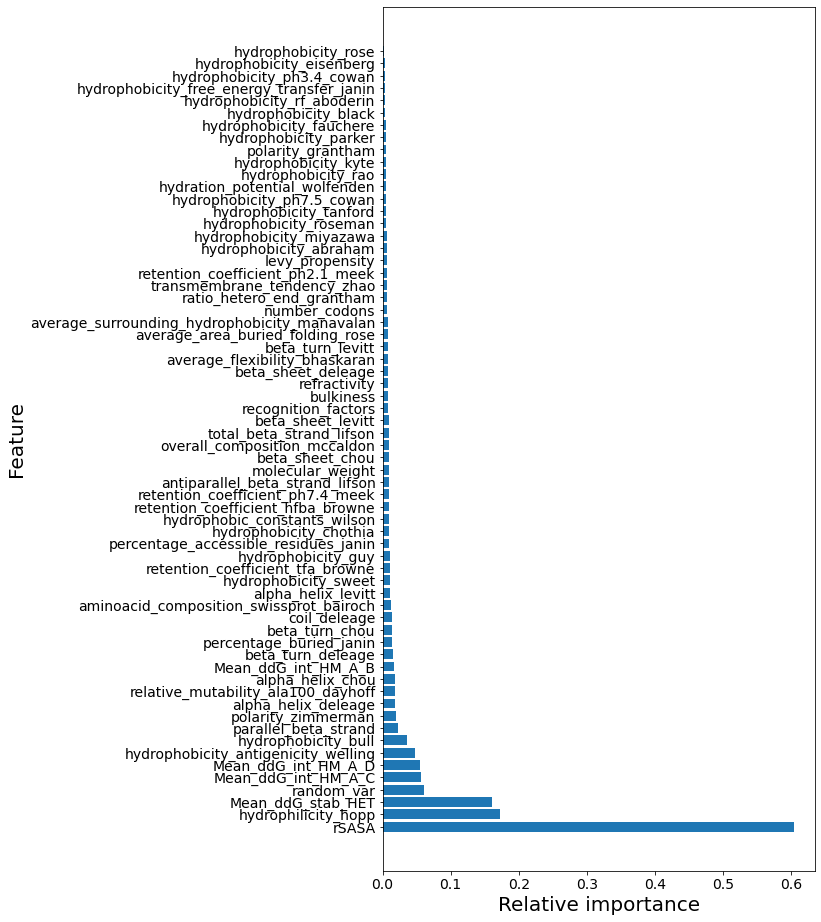

In [19]:
# Use permutation to estimate relative importances
perm_imp_rfpimp = permutation_importances(model_rf, X_train, y_train, r2)

%matplotlib inline
fig = plt.figure()

ax = fig.add_axes([0,0,1,3])
# ax = fig.add_axes()
ax.barh(list(perm_imp_rfpimp.index), perm_imp_rfpimp['Importance'])
ax.set_xlabel('Relative importance', fontsize = 20)
ax.set_ylabel('Feature', fontsize = 20)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

plt.show()


In [20]:
best_features = perm_imp_rfpimp[perm_imp_rfpimp['Importance'] >= perm_imp_rfpimp['Importance']['random_var']]
best_features

,Importance
Feature,
rSASA,0.604499
hydrophilicity_hopp,0.172707
Mean_ddG_stab_HET,0.160742
random_var,0.060335


In [21]:
new_X = X[list(best_features.index)]

# Train a new random forest with these variables and the random variable

## Let's try using a random forest model
X_train,X_test,y_train,y_test =train_test_split(new_X,Y,test_size=0.2, random_state = 100)

model_rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=100)
model_rf.fit(X_train, y_train) 
pred_train_rf= model_rf.predict(X_train)

print('Mean squared error (train):', np.sqrt(mean_squared_error(y_train,pred_train_rf)))
print('R2 score (train):', r2_score(y_train, pred_train_rf))

pred_test_rf = model_rf.predict(X_test)

print('Mean squared error (test):', np.sqrt(mean_squared_error(y_test,pred_test_rf)))
print('R2 score (test):', r2_score(y_test, pred_test_rf))


Mean squared error (train): 0.043672119331418235
R2 score (train): 0.9190015384427834
Mean squared error (test): 0.11704815409855217
R2 score (test): 0.3227982552675691


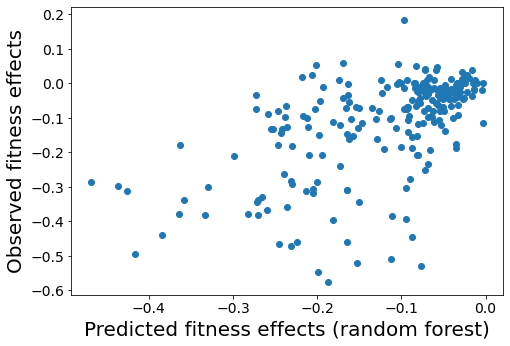

In [22]:
%matplotlib inline
## Let's get a scatterplot of the random forest predictions 
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
# ax = fig.add_axes()
ax.scatter(pred_test_rf, y_test)
ax.set_xlabel('Predicted fitness effects (random forest)', fontsize = 20)
ax.set_ylabel('Observed fitness effects', fontsize = 20)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

plt.show()

In [23]:
# X_train,X_test,y_train,y_test =train_test_split(new_X,Y,test_size=0.2, random_state = 100)

cross_val_n = 5

print('Five-fold cross validation of the random forest model:')
cross_validations = cross_val_score(estimator = model_rf, X = X_train, y = y_train, cv=cross_val_n, scoring = r2)
print(cross_validations)
print(np.mean(cross_validations), np.std(cross_validations) / np.sqrt(cross_val_n))
print('------')

cross_validations_pred = cross_val_predict(estimator = model_rf, X = X_train, y = y_train, cv=cross_val_n)

Five-fold cross validation of the random forest model:
[0.46892075 0.3533313  0.48305044 0.27528306 0.35626441]
0.38736999023841046 0.03492560445220283
------


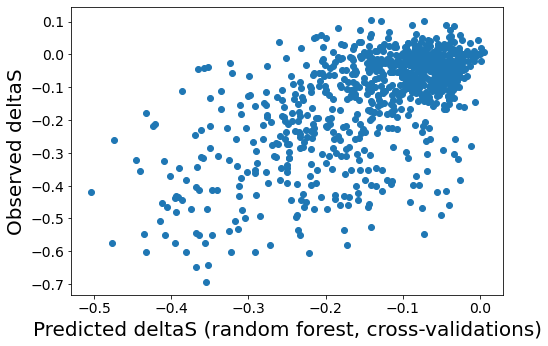

In [24]:
%matplotlib inline
## Let's get a scatterplot of the random forest predictions 
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
# ax = fig.add_axes()
ax.scatter(cross_validations_pred, y_train)
ax.set_xlabel('Predicted deltaS (random forest, cross-validations)', fontsize = 20)
ax.set_ylabel('Observed deltaS', fontsize = 20)
cross_validations_pred[1, ]
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

plt.show()

In [25]:
# Since this is a simpler model, we can implement more easily the test that leaves one variable out
# Function from https://explained.ai/rf-importance/index.html#intro
def dropcol_importances(rf, X_train, y_train):
    rf_ = clone(rf)
    rf_.random_state = 100
    rf_.fit(X_train, y_train)
    baseline = rf_.oob_score_
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = 100
        rf_.fit(X, y_train)
        o = rf_.oob_score_
        imp.append(baseline - o)
    imp = np.array(imp)
    I = pd.DataFrame(
            data={'Feature':X_train.columns,
                  'Importance':imp})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=True)
    return I

In [26]:
importances_drop_col = dropcol_importances(model_rf, X_train, y_train)

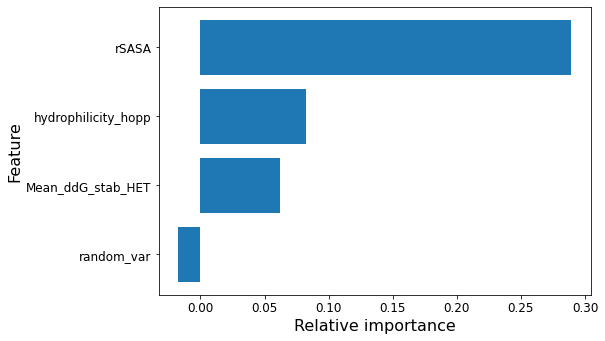

In [27]:
%matplotlib inline
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
# ax = fig.add_axes()
ax.barh(list(importances_drop_col.index), importances_drop_col['Importance'])
ax.set_xlabel('Relative importance', fontsize = 16)
ax.set_ylabel('Feature', fontsize = 16)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

plt.show()

In [28]:
### Save the tables I need
## Relative importances permutation (all)
perm_imp_rfpimp.to_csv('../../Results_ML/diffNorm_ara0.2_ara0.01/model_diffFit_permImportances_allVariables.txt', sep = '\t')

## Predictions for test set(best variables)
df_pred_test_best = pd.DataFrame(list(zip(y_test,  pred_test_rf)), columns = ['test_data', 'pred_data'])
df_pred_test_best.to_csv('../../Results_ML/diffNorm_ara0.2_ara0.01/pred_rf_bestVariables.txt', sep = '\t')

## Predictions for cross-validation (best variables)
df_pred_crossval_best = pd.DataFrame(list(zip(y_train, cross_validations_pred)), columns = ['test_data', 'pred_data'])
df_pred_crossval_best.to_csv('../../Results_ML/diffNorm_ara0.2_ara0.01/crossval_rf_bestVariables.txt', sep = '\t')

## Relative importances drop column (best variables)
importances_drop_col.to_csv('../../Results_ML/diffNorm_ara0.2_ara0.01/model_diffFit_dropCol_bestVariables.txt', sep = '\t')


## Repeat with the data without TMP

In [29]:
dataset = pd.read_csv('../../Data/dataset_diffNorm_ara0.2_ara0.01_index_differences_new_notmp.txt', sep='\t')
dataset

,Position,WT_Residue,Residue,mean_sel_coeff,Arabinose,mean_sel_coeff_2,Arabinose_2,diffNormScore,Mean_ddG_stab_HET,Mean_ddG_int_HM_A_B,...,recognition_factors,refractivity,relative_mutability_ala100_dayhoff,retention_coefficient_hfba_browne,retention_coefficient_ph2.1_meek,retention_coefficient_ph7.4_meek,retention_coefficient_tfa_browne,total_beta_strand_lifson,transmembrane_tendency_zhao,levy_propensity
0,2,E,*,0.031078,0.2,0.026107,0.01,-0.004970,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,E,A,0.012895,0.2,0.028337,0.01,0.015442,NaN,NaN,...,0.0,-12.92,-2.0,11.4,7.4,17.4,14.4,0.31,3.28,0.7955
2,2,E,C,-0.002998,0.2,0.006441,0.01,0.009439,NaN,NaN,...,11.0,18.51,-82.0,-6.8,5.3,10.1,-2.1,0.55,2.60,1.8265
3,2,E,D,0.022451,0.2,0.030444,0.01,0.007993,NaN,NaN,...,3.0,-5.26,4.0,4.7,4.7,8.7,4.2,-0.13,-0.37,0.0408
4,2,E,E,0.000036,0.2,0.000088,0.01,0.000052,NaN,NaN,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1612,78,N,S,0.025233,0.2,0.026666,0.01,0.001433,-0.05281,0.0,...,13.0,-6.93,-14.0,-0.7,-2.1,0.4,1.6,0.22,1.09,0.4069
1613,78,N,T,0.018884,0.2,0.029973,0.01,0.011089,0.01204,0.0,...,-1.0,-2.27,-37.0,3.9,3.1,1.9,6.5,0.52,1.30,0.3724
1614,78,N,V,0.016065,0.2,0.025761,0.01,0.009696,0.17377,0.0,...,-5.0,0.64,-60.0,4.9,4.9,1.9,9.2,1.21,3.08,1.0292
1615,78,N,W,0.016408,0.2,0.029399,0.01,0.012991,-0.11735,0.0,...,10.0,29.25,-116.0,20.6,19.7,14.1,22.0,0.94,3.15,1.0618


In [30]:
dataset['Mean_ddG_stab_HET']

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
1612   -0.05281
1613    0.01204
1614    0.17377
1615   -0.11735
1616   -0.04273
Name: Mean_ddG_stab_HET, Length: 1617, dtype: float64

In [31]:
# Remove stop codons and rows that are not present in the PDB structure
dataset = dataset[(dataset['Residue'] != '*') & 
                  (pd.notna(dataset['Mean_ddG_stab_HET'])) &
                  (pd.notna(dataset['diffNormScore']))
                 ]

df = dataset.drop(['Entropy','Position','WT_Residue', 'Residue', 'Arabinose',
                   'Secondary_structure','Solvent_accessibility', 'mean_sel_coeff', 
                   'mean_sel_coeff_2', 'Arabinose_2'],axis=1)

In [32]:
df

,diffNormScore,Mean_ddG_stab_HET,Mean_ddG_int_HM_A_B,Mean_ddG_int_HM_A_C,Mean_ddG_int_HM_A_D,rSASA,alpha_helix_chou,alpha_helix_deleage,alpha_helix_levitt,aminoacid_composition_swissprot_bairoch,...,recognition_factors,refractivity,relative_mutability_ala100_dayhoff,retention_coefficient_hfba_browne,retention_coefficient_ph2.1_meek,retention_coefficient_ph7.4_meek,retention_coefficient_tfa_browne,total_beta_strand_lifson,transmembrane_tendency_zhao,levy_propensity
421,0.000063,0.00000,0.0,0.00000,0.0,1.07,0.00,0.000,0.00,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0000
422,0.002100,0.08217,0.0,-0.07334,0.0,1.07,-0.72,-0.523,-0.18,-6.88,...,11.0,31.43,-80.0,-18.2,-2.1,-7.3,-16.5,0.24,-0.68,1.0310
423,0.005458,0.42867,0.0,-0.03732,0.0,1.07,-0.41,-0.565,-0.25,-2.80,...,3.0,7.66,6.0,-6.7,-2.7,-8.7,-10.2,-0.44,-3.65,-0.7547
424,0.012323,0.12224,0.0,-0.14038,0.0,1.07,0.09,0.015,0.15,-1.50,...,0.0,12.92,2.0,-11.4,-7.4,-17.4,-14.4,-0.31,-3.28,-0.7955
425,0.010150,-0.52836,0.0,-0.48634,0.0,1.07,-0.29,-0.294,-0.22,-4.39,...,3.0,25.06,-59.0,10.8,14.0,12.7,11.9,0.33,1.60,1.2665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1612,0.001433,-0.05281,0.0,0.00000,0.0,1.16,0.10,-0.033,-0.08,2.50,...,13.0,-6.93,-14.0,-0.7,-2.1,0.4,1.6,0.22,1.09,0.4069
1613,0.011089,0.01204,0.0,0.00000,0.0,1.16,0.16,0.013,-0.08,1.28,...,-1.0,-2.27,-37.0,3.9,3.1,1.9,6.5,0.52,1.30,0.3724
1614,0.009696,0.17377,0.0,0.00000,0.0,1.16,0.39,0.218,0.01,2.81,...,-5.0,0.64,-60.0,4.9,4.9,1.9,9.2,1.21,3.08,1.0292
1615,0.012991,-0.11735,0.0,0.00000,0.0,1.16,0.41,0.318,0.09,-2.98,...,10.0,29.25,-116.0,20.6,19.7,14.1,22.0,0.94,3.15,1.0618


In [33]:
X = df.drop(['diffNormScore'],axis=1)
Y = df['diffNormScore']

# Normalize all the features to the range of -1 , 1
X = X / X.max()

In [34]:
## Let's try using a random forest model
X_train,X_test,y_train,y_test =train_test_split(X,Y,test_size=0.2, random_state=100)

model_rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=100)
model_rf.fit(X_train, y_train) 
pred_train_rf= model_rf.predict(X_train)

print('Mean squared error (train):', np.sqrt(mean_squared_error(y_train,pred_train_rf)))
print('R2 score (train):', r2_score(y_train, pred_train_rf))

pred_test_rf = model_rf.predict(X_test)

print('Mean squared error (test):', np.sqrt(mean_squared_error(y_test,pred_test_rf)))
print('R2 score (test):', r2_score(y_test, pred_test_rf))

Mean squared error (train): 0.003853777044515878
R2 score (train): 0.8408006990949304
Mean squared error (test): 0.01030066217440244
R2 score (test): -0.13426216825512638


In [35]:
## Let's train the random forest again but adding a random variable
np.random.seed(100)
X['random_var'] = np.random.normal(loc = 0, scale = 1, size = X.shape[0])

## Let's try using a random forest model
X_train,X_test,y_train,y_test =train_test_split(X,Y,test_size=0.2, random_state = 100)

model_rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=100)
model_rf.fit(X_train, y_train) 
pred_train_rf= model_rf.predict(X_train)

print('Mean squared error (train):', np.sqrt(mean_squared_error(y_train,pred_train_rf)))
print('R2 score (train):', r2_score(y_train, pred_train_rf))

pred_test_rf = model_rf.predict(X_test)

print('Mean squared error (test):', np.sqrt(mean_squared_error(y_test,pred_test_rf)))
print('R2 score (test):', r2_score(y_test, pred_test_rf))

Mean squared error (train): 0.0038040014298594076
R2 score (train): 0.8448865961076579
Mean squared error (test): 0.010149343857499672
R2 score (test): -0.10118197017619823


Let's try using cross-validation

In [41]:
cross_val_n = 5
print('Five-fold cross validation of the random forest model:')
cross_validations = cross_val_score(estimator = model_rf, X = X_train, y = y_train, cv=cross_val_n , scoring = r2)
print(cross_validations)
print(np.mean(cross_validations), np.std(cross_validations))
print('------')

Five-fold cross validation of the random forest model:
[-0.16088438 -0.21235267 -0.18210967 -0.03407111 -0.13191679]
-0.1442669220751392 0.0610565733402177
------


In [42]:
cross_validations = cross_val_score(estimator = model_rf, X = X_train, y = y_train, cv=5, scoring = r2)
print(cross_validations)

[-0.16088438 -0.21235267 -0.18210967 -0.03407111 -0.13191679]


In [43]:
## Try using cross_val_predict to see how the cross-validation predicted each data point when it was in the
## test set
cross_validations_pred = cross_val_predict(estimator = model_rf, X = X_train, y = y_train, cv=5)

In [44]:
print(len(cross_validations_pred))
print(len(y_train))

912
912


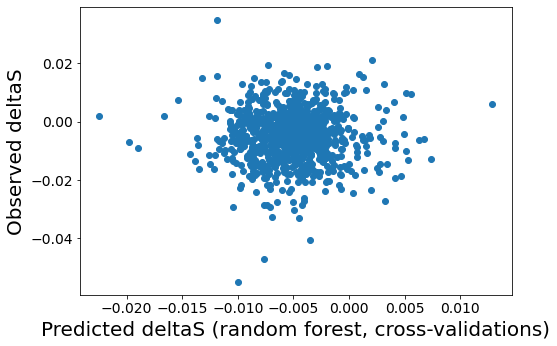

In [45]:
%matplotlib inline
## Let's get a scatterplot of the random forest predictions 
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
# ax = fig.add_axes()
ax.scatter(cross_validations_pred, y_train)
ax.set_xlabel('Predicted deltaS (random forest, cross-validations)', fontsize = 20)
ax.set_ylabel('Observed deltaS', fontsize = 20)
cross_validations_pred[1, ]
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

plt.show()

Figures for the accuracy of the predictions and selecting the best variables

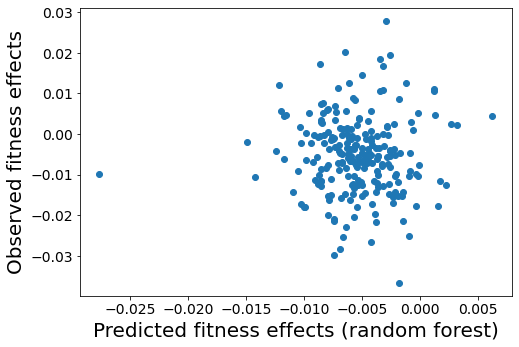

In [46]:
%matplotlib inline
## Let's get a scatterplot of the random forest predictions 
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
# ax = fig.add_axes()
ax.scatter(pred_test_rf, y_test)
ax.set_xlabel('Predicted fitness effects (random forest)', fontsize = 20)
ax.set_ylabel('Observed fitness effects', fontsize = 20)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

plt.show()

In [47]:
## Should save the corresponding files for predictions on validation set and test set
# Save test data and predictions to repeat figures in R

## Results with all variables
df_pred_test = pd.DataFrame(list(zip(y_test,  pred_test_rf)), columns = ['test_data', 'pred_data'])
df_pred_test.to_csv('../../Results_ML/diffNorm_ara0.2_ara0.01/pred_rf_allVariables_notmp.txt', sep = '\t')

## Results of predictions in the cross-validation
df_pred_crossval = pd.DataFrame(list(zip(y_train, cross_validations_pred)), columns = ['test_data', 'pred_data'])
df_pred_crossval.to_csv('../../Results_ML/diffNorm_ara0.2_ara0.01/crossval_rf_allVariables_notmp.txt', sep = '\t')



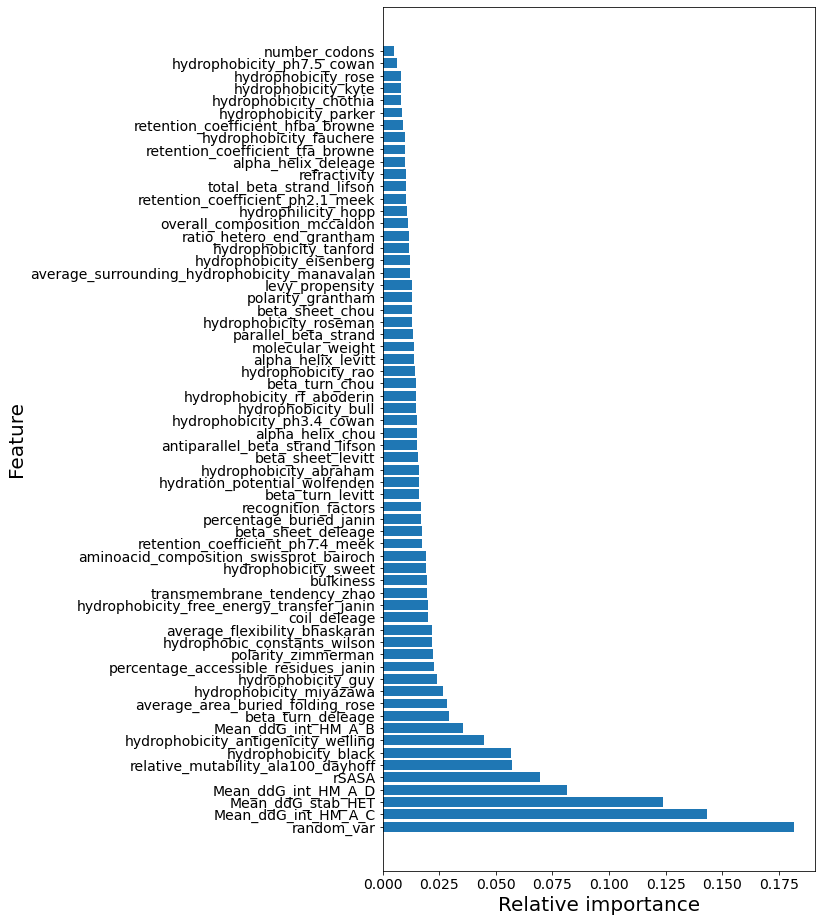

In [48]:
# Use permutation to estimate relative importances
perm_imp_rfpimp = permutation_importances(model_rf, X_train, y_train, r2)

%matplotlib inline
fig = plt.figure()

ax = fig.add_axes([0,0,1,3])
# ax = fig.add_axes()
ax.barh(list(perm_imp_rfpimp.index), perm_imp_rfpimp['Importance'])
ax.set_xlabel('Relative importance', fontsize = 20)
ax.set_ylabel('Feature', fontsize = 20)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

plt.show()


In [50]:
### Save the tables I need
## Relative importances permutation (all)
perm_imp_rfpimp.to_csv('../../Results_ML/diffNorm_ara0.2_ara0.01/model_diffFit_permImportances_allVariables_notmp.txt', sep = '\t')

## Probably not going to use the rest of the code 

It works with the significant mutants in the ANOVA and the random forest classifier for my somewhat arbitrary classes of mutants.

## Work with only the mutants that were significant in the ANOVA

In [26]:
dataset = pd.read_csv('../../Data/dataset_diffNorm_ara0.2_ara0.01_index_differences_significant.txt', sep='\t')
dataset

,Position,WT_Residue,Residue,mean_sel_coeff,sem_sel_coeff,Arabinose,ID,p.adj,mut_check,exp_level,...,recognition_factors,refractivity,relative_mutability_ala100_dayhoff,retention_coefficient_hfba_browne,retention_coefficient_ph2.1_meek,retention_coefficient_ph7.4_meek,retention_coefficient_tfa_browne,total_beta_strand_lifson,transmembrane_tendency_zhao,levy_propensity
0,2,E,*,-0.169225,0.021940,0.2,2*,2.452422e-04,True,Optimal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,E,A,0.082310,0.008775,0.2,2A,2.854064e-15,True,Optimal,...,0.0,-12.92,-2.0,11.4,7.4,17.4,14.4,0.31,3.28,0.7955
2,2,E,C,0.069291,0.011577,0.2,2C,1.422414e-13,True,Optimal,...,11.0,18.51,-82.0,-6.8,5.3,10.1,-2.1,0.55,2.60,1.8265
3,2,E,D,0.068931,0.006676,0.2,2D,2.104146e-05,True,Optimal,...,3.0,-5.26,4.0,4.7,4.7,8.7,4.2,-0.13,-0.37,0.0408
4,2,E,E,0.000121,0.000028,0.2,2E,5.022950e-12,True,Optimal,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1164,78,N,R,0.055897,0.008019,0.2,78R,4.629307e-03,True,Optimal,...,1.0,13.38,-69.0,6.0,-2.9,0.0,2.1,0.33,-0.95,0.1817
1165,78,N,S,0.054845,0.008369,0.2,78S,3.448701e-02,True,Optimal,...,13.0,-6.93,-14.0,-0.7,-2.1,0.4,1.6,0.22,1.09,0.4069
1166,78,N,T,0.057005,0.006086,0.2,78T,1.360611e-03,True,Optimal,...,-1.0,-2.27,-37.0,3.9,3.1,1.9,6.5,0.52,1.30,0.3724
1167,78,N,W,0.043108,0.008729,0.2,78W,8.852615e-07,True,Optimal,...,10.0,29.25,-116.0,20.6,19.7,14.1,22.0,0.94,3.15,1.0618


In [27]:
# Remove stop codons and rows that are not present in the PDB structure
dataset = dataset[(dataset['Residue'] != '*') & 
                  (pd.notna(dataset['Mean_ddG_stab_HET'])) &
                  (pd.notna(dataset['diffNormScore']))
                 ]

df = dataset.drop(['Entropy','WT_Residue', 'Residue', 'Arabinose', 'ID', 'p.adj',
                   'Solvent_accessibility', 'mean_sel_coeff', 
                   'sem_sel_coeff', 'mut_check', 'exp_level', 'mean_fluo',
                   'mut_check_final', 'mut_check_diff'],axis=1)

In [28]:
# Load the dataset with the annotation for interfaces
data_interfaces = pd.read_csv('../../Data/Complete_datasets_TMP0_TMP10/data_annotation_2.txt', sep = '\t')

data_interfaces.columns = ['Region_' + colname for colname in data_interfaces.columns]
data_interfaces

,Region_Position,"Region_A,C","Region_A,D",Region_DHF,Region_NADPH,Region_Cat_residues
0,2,0,0,0,0,0
1,3,0,0,0,0,0
2,4,0,0,0,0,0
3,5,0,0,0,0,0
4,6,0,0,0,0,0
...,...,...,...,...,...,...
72,74,0,0,0,0,0
73,75,0,0,0,0,0
74,76,0,0,0,0,0
75,77,0,0,0,0,0


In [29]:
data_new = pd.get_dummies(df.Secondary_structure, prefix = 'secStruc')
data_new

,secStruc_3/10 helix,secStruc_Bend,secStruc_Beta ladder,secStruc_H-bonded turn,secStruc_none
374,0,0,0,0,1
375,0,0,0,0,1
376,0,0,0,0,1
377,0,0,0,0,1
378,0,0,0,0,1
...,...,...,...,...,...
1164,0,0,0,0,1
1165,0,0,0,0,1
1166,0,0,0,0,1
1167,0,0,0,0,1


In [30]:
# Drop secondary structure and add the one-hot encoded columns
df_final = df.drop(['Secondary_structure'], axis = 1)

df_final = pd.concat([df_final, data_new], axis = 1)

df_final

,Position,diffNormScore,Mean_ddG_stab_HET,Mean_ddG_int_HM_A_B,Mean_ddG_int_HM_A_C,Mean_ddG_int_HM_A_D,rSASA,alpha_helix_chou,alpha_helix_deleage,alpha_helix_levitt,...,retention_coefficient_ph7.4_meek,retention_coefficient_tfa_browne,total_beta_strand_lifson,transmembrane_tendency_zhao,levy_propensity,secStruc_3/10 helix,secStruc_Bend,secStruc_Beta ladder,secStruc_H-bonded turn,secStruc_none
374,22,-0.000231,0.00000,0.0,0.00000,0.0,1.07,0.00,0.000,0.00,...,0.0,0.0,0.00,0.00,0.0000,0,0,0,0,1
375,22,-0.011407,0.08217,0.0,-0.07334,0.0,1.07,-0.72,-0.523,-0.18,...,-7.3,-16.5,0.24,-0.68,1.0310,0,0,0,0,1
376,22,-0.135871,0.42867,0.0,-0.03732,0.0,1.07,-0.41,-0.565,-0.25,...,-8.7,-10.2,-0.44,-3.65,-0.7547,0,0,0,0,1
377,22,-0.225430,0.12224,0.0,-0.14038,0.0,1.07,0.09,0.015,0.15,...,-17.4,-14.4,-0.31,-3.28,-0.7955,0,0,0,0,1
378,22,-0.097742,-0.52836,0.0,-0.48634,0.0,1.07,-0.29,-0.294,-0.22,...,12.7,11.9,0.33,1.60,1.2665,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1164,78,-0.016816,-0.10732,0.0,0.00000,0.0,1.16,0.31,0.452,0.06,...,0.0,2.1,0.33,-0.95,0.1817,0,0,0,0,1
1165,78,0.015845,-0.05281,0.0,0.00000,0.0,1.16,0.10,-0.033,-0.08,...,0.4,1.6,0.22,1.09,0.4069,0,0,0,0,1
1166,78,0.014005,0.01204,0.0,0.00000,0.0,1.16,0.16,0.013,-0.08,...,1.9,6.5,0.52,1.30,0.3724,0,0,0,0,1
1167,78,-0.118767,-0.11735,0.0,0.00000,0.0,1.16,0.41,0.318,0.09,...,14.1,22.0,0.94,3.15,1.0618,0,0,0,0,1


In [31]:
# Use a join to add the protein regions
df_final = pd.merge(df_final, data_interfaces, left_on = 'Position', right_on = 'Region_Position',
                   how = 'left')
df_final

,Position,diffNormScore,Mean_ddG_stab_HET,Mean_ddG_int_HM_A_B,Mean_ddG_int_HM_A_C,Mean_ddG_int_HM_A_D,rSASA,alpha_helix_chou,alpha_helix_deleage,alpha_helix_levitt,...,secStruc_Bend,secStruc_Beta ladder,secStruc_H-bonded turn,secStruc_none,Region_Position,"Region_A,C","Region_A,D",Region_DHF,Region_NADPH,Region_Cat_residues
0,22,-0.000231,0.00000,0.0,0.00000,0.0,1.07,0.00,0.000,0.00,...,0,0,0,1,22,0,0,0,0,0
1,22,-0.011407,0.08217,0.0,-0.07334,0.0,1.07,-0.72,-0.523,-0.18,...,0,0,0,1,22,0,0,0,0,0
2,22,-0.135871,0.42867,0.0,-0.03732,0.0,1.07,-0.41,-0.565,-0.25,...,0,0,0,1,22,0,0,0,0,0
3,22,-0.225430,0.12224,0.0,-0.14038,0.0,1.07,0.09,0.015,0.15,...,0,0,0,1,22,0,0,0,0,0
4,22,-0.097742,-0.52836,0.0,-0.48634,0.0,1.07,-0.29,-0.294,-0.22,...,0,0,0,1,22,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,78,-0.016816,-0.10732,0.0,0.00000,0.0,1.16,0.31,0.452,0.06,...,0,0,0,1,78,0,0,0,0,0
763,78,0.015845,-0.05281,0.0,0.00000,0.0,1.16,0.10,-0.033,-0.08,...,0,0,0,1,78,0,0,0,0,0
764,78,0.014005,0.01204,0.0,0.00000,0.0,1.16,0.16,0.013,-0.08,...,0,0,0,1,78,0,0,0,0,0
765,78,-0.118767,-0.11735,0.0,0.00000,0.0,1.16,0.41,0.318,0.09,...,0,0,0,1,78,0,0,0,0,0


In [32]:
X = df_final.drop(['diffNormScore', 'Position', 'Region_Position'],axis=1)
Y = df_final['diffNormScore']

# Normalize all the features to the range of -1 , 1
X = X / X.max()

X

,Mean_ddG_stab_HET,Mean_ddG_int_HM_A_B,Mean_ddG_int_HM_A_C,Mean_ddG_int_HM_A_D,rSASA,alpha_helix_chou,alpha_helix_deleage,alpha_helix_levitt,aminoacid_composition_swissprot_bairoch,antiparallel_beta_strand_lifson,...,secStruc_3/10 helix,secStruc_Bend,secStruc_Beta ladder,secStruc_H-bonded turn,secStruc_none,"Region_A,C","Region_A,D",Region_DHF,Region_NADPH,Region_Cat_residues
0,0.000000,0.0,0.000000,0.0,0.922414,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.002148,0.0,-0.001754,0.0,0.922414,-0.765957,-0.516798,-0.189474,-0.801865,0.255639,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.011206,0.0,-0.000893,0.0,0.922414,-0.436170,-0.558300,-0.263158,-0.326340,-0.323308,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.003196,0.0,-0.003358,0.0,0.922414,0.095745,0.014822,0.157895,-0.174825,-0.210526,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-0.013812,0.0,-0.011632,0.0,0.922414,-0.308511,-0.290514,-0.231579,-0.511655,0.248120,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,-0.002805,0.0,0.000000,0.0,1.000000,0.329787,0.446640,0.063158,0.171329,0.300752,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
763,-0.001381,0.0,0.000000,0.0,1.000000,0.106383,-0.032609,-0.084211,0.291375,0.187970,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
764,0.000315,0.0,0.000000,0.0,1.000000,0.170213,0.012846,-0.084211,0.149184,0.511278,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
765,-0.003068,0.0,0.000000,0.0,1.000000,0.436170,0.314229,0.094737,-0.347319,0.849624,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [33]:
## Let's try using a random forest model
X_train,X_test,y_train,y_test =train_test_split(X,Y,test_size=0.2, random_state=100)

model_rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=100)
model_rf.fit(X_train, y_train) 
pred_train_rf= model_rf.predict(X_train)

print('Mean squared error (train):', np.sqrt(mean_squared_error(y_train,pred_train_rf)))
print('R2 score (train):', r2_score(y_train, pred_train_rf))

pred_test_rf = model_rf.predict(X_test)

print('Mean squared error (test):', np.sqrt(mean_squared_error(y_test,pred_test_rf)))
print('R2 score (test):', r2_score(y_test, pred_test_rf))

Mean squared error (train): 0.052561096588849957
R2 score (train): 0.9053726352890952
Mean squared error (test): 0.14110653842723905
R2 score (test): 0.25269385744313244


In [34]:
## Let's train the random forest again but adding a random variable
np.random.seed(100)
X['random_var'] = np.random.normal(loc = 0, scale = 1, size = X.shape[0])

## Let's try using a random forest model
X_train,X_test,y_train,y_test =train_test_split(X,Y,test_size=0.2, random_state = 100)

model_rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=100)
model_rf.fit(X_train, y_train) 
pred_train_rf= model_rf.predict(X_train)

print('Mean squared error (train):', np.sqrt(mean_squared_error(y_train,pred_train_rf)))
print('R2 score (train):', r2_score(y_train, pred_train_rf))

pred_test_rf = model_rf.predict(X_test)

print('Mean squared error (test):', np.sqrt(mean_squared_error(y_test,pred_test_rf)))
print('R2 score (test):', r2_score(y_test, pred_test_rf))

Mean squared error (train): 0.052976516015775875
R2 score (train): 0.9038709394455603
Mean squared error (test): 0.14166109767811638
R2 score (test): 0.2468083768566801


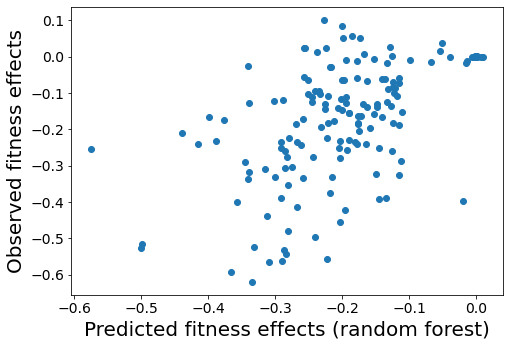

In [35]:
%matplotlib inline
## Let's get a scatterplot of the random forest predictions 
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
# ax = fig.add_axes()
ax.scatter(pred_test_rf, y_test)
ax.set_xlabel('Predicted fitness effects (random forest)', fontsize = 20)
ax.set_ylabel('Observed fitness effects', fontsize = 20)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

plt.show()

In [36]:
# Use permutation to estimate relative importances
def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

perm_imp_rfpimp = permutation_importances(model_rf, X_train, y_train, r2)

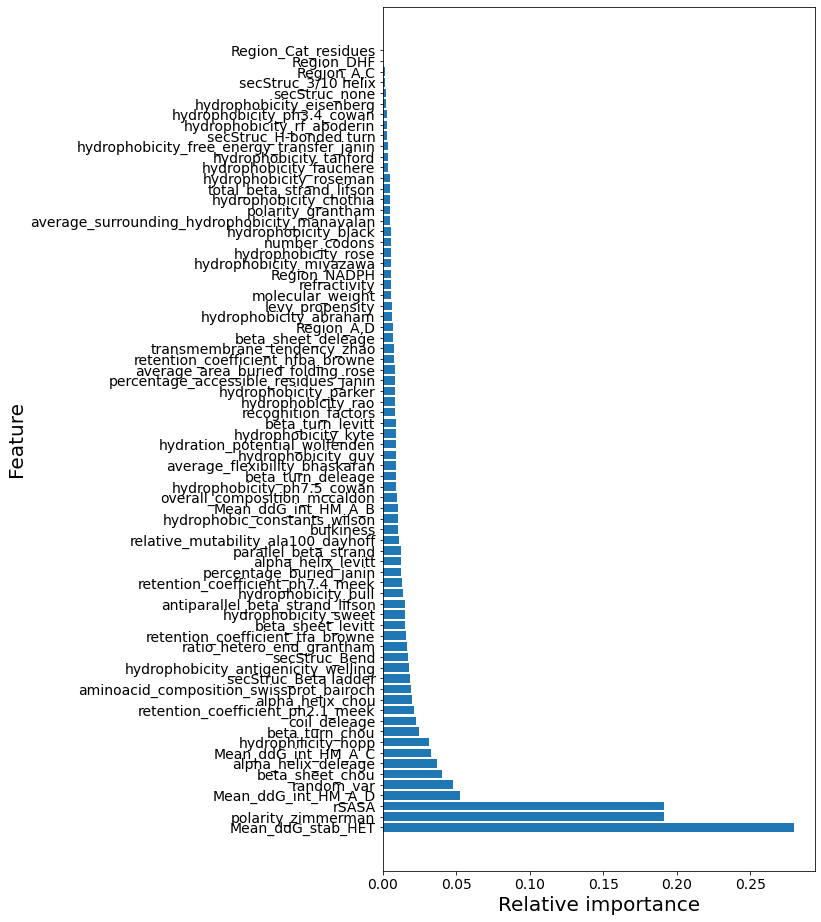

In [37]:
%matplotlib inline
fig = plt.figure()

ax = fig.add_axes([0,0,1,3])
# ax = fig.add_axes()
ax.barh(list(perm_imp_rfpimp.index), perm_imp_rfpimp['Importance'])
ax.set_xlabel('Relative importance', fontsize = 20)
ax.set_ylabel('Feature', fontsize = 20)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

plt.show()


In [38]:
## Let's select all the variables that are more important than the random variable
# These are always rSASA, ddG_stab, ddG_int_A_C
# They include ddG_int_A_D almost always, and often a variable on hydrophobicity or alpha helix propensity
best_features = perm_imp_rfpimp[perm_imp_rfpimp['Importance'] > perm_imp_rfpimp['Importance']['random_var']]
new_X = X[list(best_features.index) + ['random_var']]
new_X

,Mean_ddG_stab_HET,polarity_zimmerman,rSASA,Mean_ddG_int_HM_A_D,random_var
0,0.000000,0.000000,0.922414,0.0,-1.749765
1,0.002148,0.028462,0.922414,0.0,0.342680
2,0.011206,0.955769,0.922414,0.0,1.153036
3,0.003196,0.959615,0.922414,0.0,-0.252436
4,-0.013812,0.006731,0.922414,0.0,0.981321
...,...,...,...,...,...
762,-0.002805,0.935000,1.000000,0.0,0.627888
763,-0.001381,-0.032885,1.000000,0.0,0.952705
764,0.000315,-0.033077,1.000000,0.0,-0.829628
765,-0.003068,-0.024615,1.000000,0.0,1.160466


In [39]:
# Train a new random forest with these variables and the random variable

## Let's try using a random forest model
X_train,X_test,y_train,y_test =train_test_split(new_X,Y,test_size=0.2, random_state = 100)

model_rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=100)
model_rf.fit(X_train, y_train) 
pred_train_rf= model_rf.predict(X_train)

print('Mean squared error (train):', np.sqrt(mean_squared_error(y_train,pred_train_rf)))
print('R2 score (train):', r2_score(y_train, pred_train_rf))

pred_test_rf = model_rf.predict(X_test)

print('Mean squared error (test):', np.sqrt(mean_squared_error(y_test,pred_test_rf)))
print('R2 score (test):', r2_score(y_test, pred_test_rf))


Mean squared error (train): 0.05316173007547428
R2 score (train): 0.9031976004471649
Mean squared error (test): 0.1351208703990908
R2 score (test): 0.3147498422532382


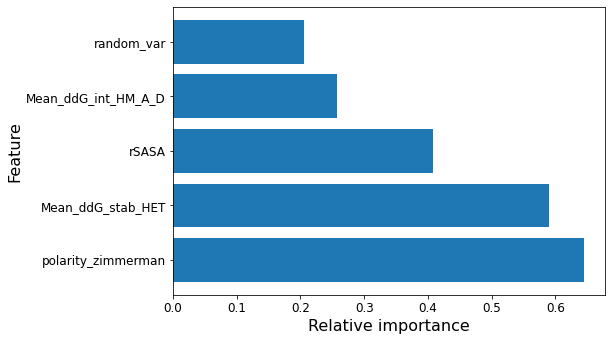

In [40]:
perm_imp_rfpimp = permutation_importances(model_rf, X_train, y_train, r2)
%matplotlib inline
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
# ax = fig.add_axes()
ax.barh(list(perm_imp_rfpimp.index), perm_imp_rfpimp['Importance'])
ax.set_xlabel('Relative importance', fontsize = 16)
ax.set_ylabel('Feature', fontsize = 16)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

plt.show()

In [41]:
# Since this is a simpler model, we can implement more easily the test that leaves one variable out
# Function from https://explained.ai/rf-importance/index.html#intro
def dropcol_importances(rf, X_train, y_train):
    rf_ = clone(rf)
    rf_.random_state = 100
    rf_.fit(X_train, y_train)
    baseline = rf_.oob_score_
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = 100
        rf_.fit(X, y_train)
        o = rf_.oob_score_
        imp.append(baseline - o)
    imp = np.array(imp)
    I = pd.DataFrame(
            data={'Feature':X_train.columns,
                  'Importance':imp})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=True)
    return I

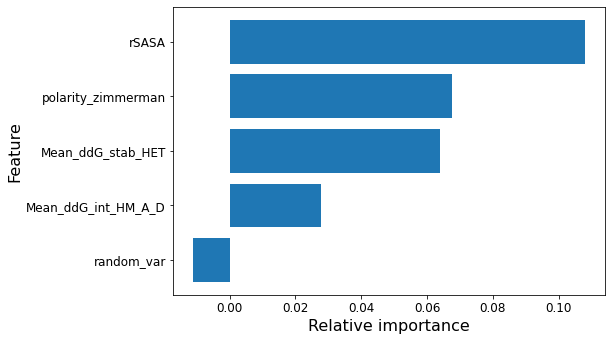

In [42]:
importances_drop_col = dropcol_importances(model_rf, X_train, y_train)

%matplotlib inline
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
# ax = fig.add_axes()
ax.barh(list(importances_drop_col.index), importances_drop_col['Importance'])
ax.set_xlabel('Relative importance', fontsize = 16)
ax.set_ylabel('Feature', fontsize = 16)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

plt.show()

Let's try training with cross-validation

In [43]:
# X_train,X_test,y_train,y_test =train_test_split(new_X,Y,test_size=0.2, random_state = 100)

model_rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=100)
model_rf.fit(X_train, y_train) 
y_pred= model_rf.predict(X_test)
print('Accuracy of the Random forest model is '+str(r2_score(y_test,y_pred)))
print('Ten-fold cross validation of the random forest model:')
cross_validations = cross_val_score(estimator = model_rf, X = X_train, y = y_train, cv=10, scoring = r2)
print(cross_validations)
print(np.mean(cross_validations), np.std(cross_validations))
print('------')

Accuracy of the Random forest model is 0.3147498422532382
Ten-fold cross validation of the random forest model:
[ 0.36710774  0.37318812  0.45477559  0.27617777  0.23467983  0.14504502
  0.27896839 -0.00168342  0.18365132  0.45401922]
0.27659295974872894 0.1363436682014992
------


## Let's try a random forest classifier

In [62]:
dataset = pd.read_csv('../../Data/dataset_diffNorm_ara0.2_ara0.01_index_differences_significant_class.txt', sep='\t')
dataset

,Position,WT_Residue,Residue,diffNormScore,ara0.01,ara0.2,Class,Class_num,Mean_ddG_stab_HET,Mean_ddG_int_HM_A_B,...,recognition_factors,refractivity,relative_mutability_ala100_dayhoff,retention_coefficient_hfba_browne,retention_coefficient_ph2.1_meek,retention_coefficient_ph7.4_meek,retention_coefficient_tfa_browne,total_beta_strand_lifson,transmembrane_tendency_zhao,levy_propensity
0,2,E,*,0.123333,-0.045891,-0.169225,Fitter at lower expression,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,E,A,0.281523,0.363833,0.082310,Fitter at lower expression,4,NaN,NaN,...,0.0,-12.92,-2.0,11.4,7.4,17.4,14.4,0.31,3.28,0.7955
2,2,E,C,0.311297,0.380588,0.069291,Fitter at lower expression,4,NaN,NaN,...,11.0,18.51,-82.0,-6.8,5.3,10.1,-2.1,0.55,2.60,1.8265
3,2,E,D,0.067978,0.136909,0.068931,WT-like,0,NaN,NaN,...,3.0,-5.26,4.0,4.7,4.7,8.7,4.2,-0.13,-0.37,0.0408
4,2,E,E,0.003083,0.003203,0.000121,WT-like,0,NaN,NaN,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1612,78,N,S,0.015845,0.070690,0.054845,WT-like,0,-0.05281,0.0,...,13.0,-6.93,-14.0,-0.7,-2.1,0.4,1.6,0.22,1.09,0.4069
1613,78,N,T,0.014005,0.071010,0.057005,WT-like,0,0.01204,0.0,...,-1.0,-2.27,-37.0,3.9,3.1,1.9,6.5,0.52,1.30,0.3724
1614,78,N,V,-0.000102,0.043937,0.044039,WT-like,0,0.17377,0.0,...,-5.0,0.64,-60.0,4.9,4.9,1.9,9.2,1.21,3.08,1.0292
1615,78,N,W,-0.118767,-0.075659,0.043108,Fully compensated at optimal expression,3,-0.11735,0.0,...,10.0,29.25,-116.0,20.6,19.7,14.1,22.0,0.94,3.15,1.0618


In [63]:
# Remove stop codons and rows that are not present in the PDB structure
dataset = dataset[(dataset['Residue'] != '*') & 
                  (pd.notna(dataset['Mean_ddG_stab_HET'])) &
                  (pd.notna(dataset['diffNormScore']))
                 ]

df = dataset.drop(['Entropy','WT_Residue', 'Residue', 'ara0.01', 'ara0.2', 
                   'Solvent_accessibility', 'Class'],axis=1)

In [64]:
# Load the dataset with the annotation for interfaces
data_interfaces = pd.read_csv('../../Data/Complete_datasets_TMP0_TMP10/data_annotation_2.txt', sep = '\t')

data_interfaces.columns = ['Region_' + colname for colname in data_interfaces.columns]
data_interfaces

,Region_Position,"Region_A,C","Region_A,D",Region_DHF,Region_NADPH,Region_Cat_residues
0,2,0,0,0,0,0
1,3,0,0,0,0,0
2,4,0,0,0,0,0
3,5,0,0,0,0,0
4,6,0,0,0,0,0
...,...,...,...,...,...,...
72,74,0,0,0,0,0
73,75,0,0,0,0,0
74,76,0,0,0,0,0
75,77,0,0,0,0,0


In [65]:
data_new = pd.get_dummies(df.Secondary_structure, prefix = 'secStruc')
data_new

,secStruc_3/10 helix,secStruc_Bend,secStruc_Beta ladder,secStruc_H-bonded turn,secStruc_none
421,0,0,0,0,1
422,0,0,0,0,1
423,0,0,0,0,1
424,0,0,0,0,1
425,0,0,0,0,1
...,...,...,...,...,...
1612,0,0,0,0,1
1613,0,0,0,0,1
1614,0,0,0,0,1
1615,0,0,0,0,1


In [66]:
# Drop secondary structure and add the one-hot encoded columns
df_final = df.drop(['Secondary_structure'], axis = 1)

df_final = pd.concat([df_final, data_new], axis = 1)

df_final

,Position,diffNormScore,Class_num,Mean_ddG_stab_HET,Mean_ddG_int_HM_A_B,Mean_ddG_int_HM_A_C,Mean_ddG_int_HM_A_D,rSASA,alpha_helix_chou,alpha_helix_deleage,...,retention_coefficient_ph7.4_meek,retention_coefficient_tfa_browne,total_beta_strand_lifson,transmembrane_tendency_zhao,levy_propensity,secStruc_3/10 helix,secStruc_Bend,secStruc_Beta ladder,secStruc_H-bonded turn,secStruc_none
421,22,-0.000231,0,0.00000,0.0,0.00000,0.0,1.07,0.00,0.000,...,0.0,0.0,0.00,0.00,0.0000,0,0,0,0,1
422,22,-0.011407,0,0.08217,0.0,-0.07334,0.0,1.07,-0.72,-0.523,...,-7.3,-16.5,0.24,-0.68,1.0310,0,0,0,0,1
423,22,-0.135871,2,0.42867,0.0,-0.03732,0.0,1.07,-0.41,-0.565,...,-8.7,-10.2,-0.44,-3.65,-0.7547,0,0,0,0,1
424,22,-0.225430,2,0.12224,0.0,-0.14038,0.0,1.07,0.09,0.015,...,-17.4,-14.4,-0.31,-3.28,-0.7955,0,0,0,0,1
425,22,-0.097742,0,-0.52836,0.0,-0.48634,0.0,1.07,-0.29,-0.294,...,12.7,11.9,0.33,1.60,1.2665,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1612,78,0.015845,0,-0.05281,0.0,0.00000,0.0,1.16,0.10,-0.033,...,0.4,1.6,0.22,1.09,0.4069,0,0,0,0,1
1613,78,0.014005,0,0.01204,0.0,0.00000,0.0,1.16,0.16,0.013,...,1.9,6.5,0.52,1.30,0.3724,0,0,0,0,1
1614,78,-0.000102,0,0.17377,0.0,0.00000,0.0,1.16,0.39,0.218,...,1.9,9.2,1.21,3.08,1.0292,0,0,0,0,1
1615,78,-0.118767,3,-0.11735,0.0,0.00000,0.0,1.16,0.41,0.318,...,14.1,22.0,0.94,3.15,1.0618,0,0,0,0,1


In [67]:
# Use a join to add the protein regions
df_final = pd.merge(df_final, data_interfaces, left_on = 'Position', right_on = 'Region_Position',
                   how = 'left')
df_final

,Position,diffNormScore,Class_num,Mean_ddG_stab_HET,Mean_ddG_int_HM_A_B,Mean_ddG_int_HM_A_C,Mean_ddG_int_HM_A_D,rSASA,alpha_helix_chou,alpha_helix_deleage,...,secStruc_Bend,secStruc_Beta ladder,secStruc_H-bonded turn,secStruc_none,Region_Position,"Region_A,C","Region_A,D",Region_DHF,Region_NADPH,Region_Cat_residues
0,22,-0.000231,0,0.00000,0.0,0.00000,0.0,1.07,0.00,0.000,...,0,0,0,1,22,0,0,0,0,0
1,22,-0.011407,0,0.08217,0.0,-0.07334,0.0,1.07,-0.72,-0.523,...,0,0,0,1,22,0,0,0,0,0
2,22,-0.135871,2,0.42867,0.0,-0.03732,0.0,1.07,-0.41,-0.565,...,0,0,0,1,22,0,0,0,0,0
3,22,-0.225430,2,0.12224,0.0,-0.14038,0.0,1.07,0.09,0.015,...,0,0,0,1,22,0,0,0,0,0
4,22,-0.097742,0,-0.52836,0.0,-0.48634,0.0,1.07,-0.29,-0.294,...,0,0,0,1,22,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,78,0.015845,0,-0.05281,0.0,0.00000,0.0,1.16,0.10,-0.033,...,0,0,0,1,78,0,0,0,0,0
1136,78,0.014005,0,0.01204,0.0,0.00000,0.0,1.16,0.16,0.013,...,0,0,0,1,78,0,0,0,0,0
1137,78,-0.000102,0,0.17377,0.0,0.00000,0.0,1.16,0.39,0.218,...,0,0,0,1,78,0,0,0,0,0
1138,78,-0.118767,3,-0.11735,0.0,0.00000,0.0,1.16,0.41,0.318,...,0,0,0,1,78,0,0,0,0,0


In [68]:
X = df_final.drop(['diffNormScore', 'Class_num', 'Position', 'Region_Position'],axis=1)
Y = df_final['Class_num']

# Normalize all the features to the range of -1 , 1
X = X / X.max()

X

,Mean_ddG_stab_HET,Mean_ddG_int_HM_A_B,Mean_ddG_int_HM_A_C,Mean_ddG_int_HM_A_D,rSASA,alpha_helix_chou,alpha_helix_deleage,alpha_helix_levitt,aminoacid_composition_swissprot_bairoch,antiparallel_beta_strand_lifson,...,secStruc_3/10 helix,secStruc_Bend,secStruc_Beta ladder,secStruc_H-bonded turn,secStruc_none,"Region_A,C","Region_A,D",Region_DHF,Region_NADPH,Region_Cat_residues
0,0.000000,0.0,0.000000,0.0,0.922414,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.002148,0.0,-0.001754,0.0,0.922414,-0.765957,-0.516798,-0.189474,-0.801865,0.255639,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.011206,0.0,-0.000893,0.0,0.922414,-0.436170,-0.558300,-0.263158,-0.326340,-0.323308,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.003196,0.0,-0.003358,0.0,0.922414,0.095745,0.014822,0.157895,-0.174825,-0.210526,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-0.013812,0.0,-0.011632,0.0,0.922414,-0.308511,-0.290514,-0.231579,-0.511655,0.248120,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,-0.001381,0.0,0.000000,0.0,1.000000,0.106383,-0.032609,-0.084211,0.291375,0.187970,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1136,0.000315,0.0,0.000000,0.0,1.000000,0.170213,0.012846,-0.084211,0.149184,0.511278,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1137,0.004543,0.0,0.000000,0.0,1.000000,0.414894,0.215415,0.010526,0.327506,0.684211,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1138,-0.003068,0.0,0.000000,0.0,1.000000,0.436170,0.314229,0.094737,-0.347319,0.849624,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [69]:
Y.value_counts()

1    378
2    326
3    225
0    207
4      4
Name: Class_num, dtype: int64

In [71]:
378 / (378 + 326 + 225 + 207 + 4)

0.33157894736842103

In [72]:
## Let's try using a random forest model
X_train,X_test,y_train,y_test =train_test_split(X,Y,test_size=0.2, random_state=100)

model_rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=100)
model_rf.fit(X_train, y_train) 
pred_train_rf= model_rf.predict(X_train)

print('Mean squared error (train):', np.sqrt(mean_squared_error(y_train,pred_train_rf)))
print('Accuracy score (train):', accuracy_score(y_train, pred_train_rf))

pred_test_rf = model_rf.predict(X_test)

print('Mean squared error (test):', np.sqrt(mean_squared_error(y_test,pred_test_rf)))
print('Accuracy score (test):', accuracy_score(y_test, pred_test_rf))

Mean squared error (train): 0.0
Accuracy score (train): 1.0
Mean squared error (test): 1.1355499479153377
Accuracy score (test): 0.5833333333333334


In [73]:
## Let's train the random forest again but adding a random variable
np.random.seed(100)
X['random_var'] = np.random.normal(loc = 0, scale = 1, size = X.shape[0])

## Let's try using a random forest model
X_train,X_test,y_train,y_test =train_test_split(X,Y,test_size=0.2, random_state = 100)

model_rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=100)
model_rf.fit(X_train, y_train) 
pred_train_rf= model_rf.predict(X_train)

print('Mean squared error (train):', np.sqrt(mean_squared_error(y_train,pred_train_rf)))
print('Accuracy score (train):', accuracy_score(y_train, pred_train_rf))
pred_test_rf = model_rf.predict(X_test)

print('Mean squared error (test):', np.sqrt(mean_squared_error(y_test,pred_test_rf)))
print('Accuracy score (test):', accuracy_score(y_test, pred_test_rf))

Mean squared error (train): 0.0
Accuracy score (train): 1.0
Mean squared error (test): 1.118033988749895
Accuracy score (test): 0.5964912280701754


In [74]:
# Use permutation to estimate relative importances
def acc_check(rf, X_train, y_train):
    return accuracy_score(y_train, rf.predict(X_train))

perm_imp_rfpimp = permutation_importances(model_rf, X_train, y_train, acc_check)

In [76]:
perm_imp_rfpimp

,Importance
Feature,
rSASA,0.080044
Mean_ddG_stab_HET,0.016447
Mean_ddG_int_HM_A_C,0.001096
Mean_ddG_int_HM_A_D,0.001096
percentage_accessible_residues_janin,0.000000
...,...
hydrophobicity_black,0.000000
hydrophobicity_antigenicity_welling,0.000000
hydrophobicity_abraham,0.000000


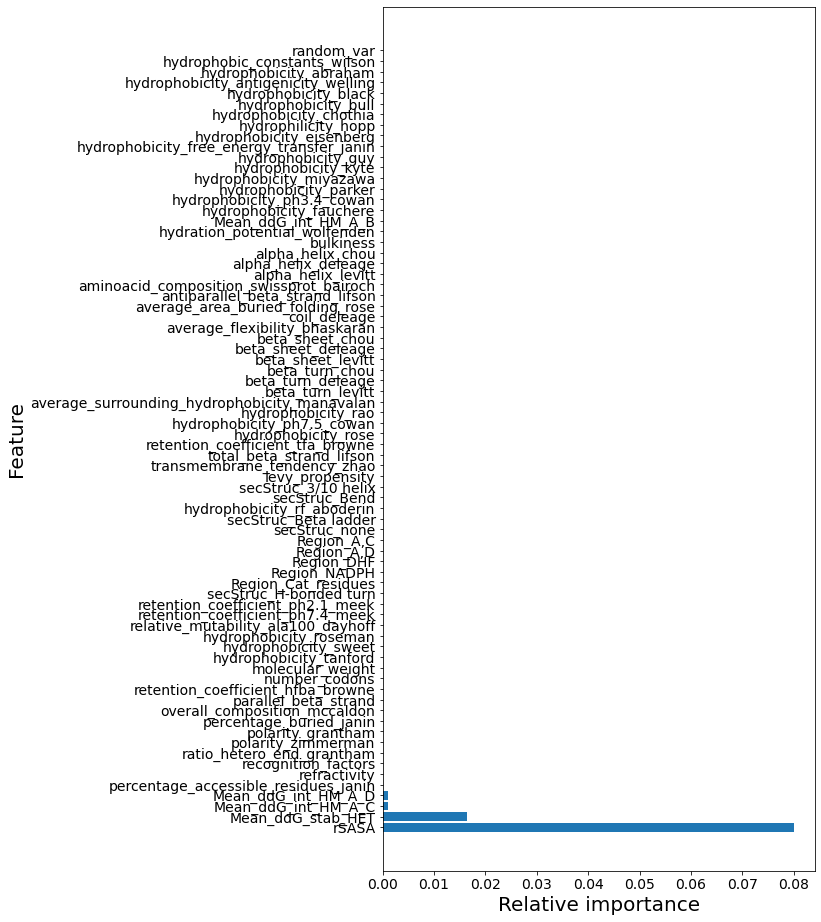

In [75]:
%matplotlib inline
fig = plt.figure()

ax = fig.add_axes([0,0,1,3])
# ax = fig.add_axes()
ax.barh(list(perm_imp_rfpimp.index), perm_imp_rfpimp['Importance'])
ax.set_xlabel('Relative importance', fontsize = 20)
ax.set_ylabel('Feature', fontsize = 20)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

plt.show()


In [77]:
## Let's select all the variables that are more important than the random variable
# These are always rSASA, ddG_stab, ddG_int_A_C
# They include ddG_int_A_D almost always, and often a variable on hydrophobicity or alpha helix propensity
best_features = perm_imp_rfpimp[perm_imp_rfpimp['Importance'] > perm_imp_rfpimp['Importance']['random_var']]
new_X = X[list(best_features.index) + ['random_var']]
new_X

,rSASA,Mean_ddG_stab_HET,Mean_ddG_int_HM_A_C,Mean_ddG_int_HM_A_D,random_var
0,0.922414,0.000000,0.000000,0.0,-1.749765
1,0.922414,0.002148,-0.001754,0.0,0.342680
2,0.922414,0.011206,-0.000893,0.0,1.153036
3,0.922414,0.003196,-0.003358,0.0,-0.252436
4,0.922414,-0.013812,-0.011632,0.0,0.981321
...,...,...,...,...,...
1135,1.000000,-0.001381,0.000000,0.0,1.563793
1136,1.000000,0.000315,0.000000,0.0,-0.638041
1137,1.000000,0.004543,0.000000,0.0,-0.704739
1138,1.000000,-0.003068,0.000000,0.0,-1.046627


In [78]:
# Train a new random forest with these variables and the random variable

## Let's try using a random forest model
X_train,X_test,y_train,y_test =train_test_split(new_X,Y,test_size=0.2, random_state = 100)

model_rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=100)
model_rf.fit(X_train, y_train) 
pred_train_rf= model_rf.predict(X_train)

print('Mean squared error (train):', np.sqrt(mean_squared_error(y_train,pred_train_rf)))
print('Accuracy score (train):', accuracy_score(y_train, pred_train_rf))

pred_test_rf = model_rf.predict(X_test)

print('Mean squared error (test):', np.sqrt(mean_squared_error(y_test,pred_test_rf)))
print('Accuracy score (test):', accuracy_score(y_test, pred_test_rf))

Mean squared error (train): 0.0
Accuracy score (train): 1.0
Mean squared error (test): 1.0982442127674488
Accuracy score (test): 0.5877192982456141


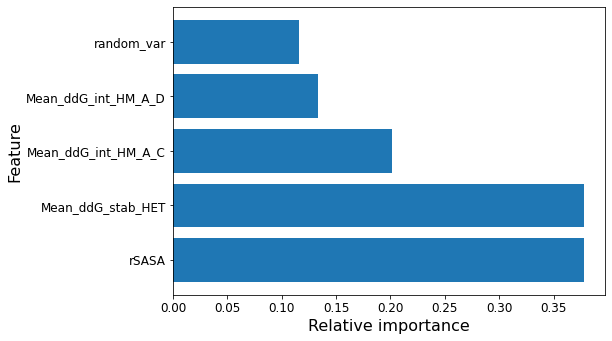

In [79]:
perm_imp_rfpimp = permutation_importances(model_rf, X_train, y_train, acc_check)
%matplotlib inline
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
# ax = fig.add_axes()
ax.barh(list(perm_imp_rfpimp.index), perm_imp_rfpimp['Importance'])
ax.set_xlabel('Relative importance', fontsize = 16)
ax.set_ylabel('Feature', fontsize = 16)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

plt.show()

In [83]:
model_rf.oob_score_

0.5789473684210527

In [89]:
# Since this is a simpler model, we can implement more easily the test that leaves one variable out
# Function from https://explained.ai/rf-importance/index.html#intro
def dropcol_importances_2(rf, X_train, y_train, X_test, y_test):
    rf_ = clone(rf)
    rf_.random_state = 100
    rf_.fit(X_train, y_train)
    # baseline = rf_.oob_score_
    
    pred_test_rf = rf_.predict(X_test)
    baseline = accuracy_score(y_test, pred_test_rf)
    
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = 100
        rf_.fit(X, y_train)
        # o = rf_.oob_score_
        
        X_test_new = X_test.drop(col, axis = 1)
        pred_test_rf = rf_.predict(X_test_new)
        o = accuracy_score(y_test, pred_test_rf)
        
        imp.append(baseline - o)
    imp = np.array(imp)
    I = pd.DataFrame(
            data={'Feature':X_train.columns,
                  'Importance':imp})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=True)
    return I

In [91]:
importances_drop_col = dropcol_importances_2(model_rf, X_train, y_train, X_test, y_test)
importances_drop_col

,Importance
Feature,
Mean_ddG_int_HM_A_D,-0.017544
Mean_ddG_int_HM_A_C,-0.004386
random_var,-0.004386
Mean_ddG_stab_HET,0.052632
rSASA,0.074561


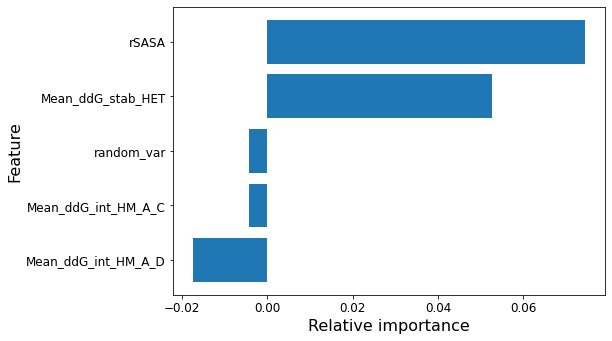

In [90]:
%matplotlib inline
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
# ax = fig.add_axes()
ax.barh(list(importances_drop_col.index), importances_drop_col['Importance'])
ax.set_xlabel('Relative importance', fontsize = 16)
ax.set_ylabel('Feature', fontsize = 16)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

plt.show()

Let's try training with cross-validation

In [82]:
# X_train,X_test,y_train,y_test =train_test_split(new_X,Y,test_size=0.2, random_state = 100)

model_rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=100)
model_rf.fit(X_train, y_train) 
y_pred= model_rf.predict(X_test)
print('Accuracy of the Random forest model is '+str(accuracy_score(y_test,y_pred)))
print('Ten-fold cross validation of the random forest model:')
cross_validations = cross_val_score(estimator = model_rf, X = X_train, y = y_train, cv=10, scoring = acc_check)
print(cross_validations)
print(np.mean(cross_validations), np.std(cross_validations))
print('------')

Accuracy of the Random forest model is 0.5877192982456141
Ten-fold cross validation of the random forest model:


/home/axelle/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


[0.61956522 0.63043478 0.57142857 0.68131868 0.63736264 0.57142857
 0.56043956 0.53846154 0.51648352 0.61538462]
0.5942307692307691 0.048146942983822306
------
